In [1]:
from cider import CIDER as MyCider
from original.tylin_cider import Cider as TylinCider
import json
from itertools import islice

## Calculating CIDEr-D score for random captions on COCO-validation

In [2]:
all_images = json.load(open('../../data/karpathy/coco/dataset.json', 'rb'))['images']
val = [i for i in all_images if i['split'] == 'val']
train = [i for i in all_images if i['split'] == 'train']

In [18]:
from transformers import BertTokenizerFast as BertTokenizer
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import torch
import random

tkz = BertTokenizer.from_pretrained('google-bert/bert-base-cased', bos_token="<BOS>", eos_token="<EOS>", pad_token="<PAD>")
val_refs = {img['imgid']: tkz([ref['raw'] for ref in img['sentences']], add_special_tokens=False)['input_ids'] for img in tqdm(val)}
val_refs = {id: r for id, r in val_refs.items() if len(r) == 5} # drop the 10 images with 6 captions

  0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
train_refs = [tkz(ref['raw'], add_special_tokens=False)['input_ids'] for img in tqdm(train) for ref in img['sentences']]

100%|██████████| 82783/82783 [00:46<00:00, 1768.87it/s]


In [5]:
from collections import defaultdict
train_uni_df = defaultdict(int)
for ref in tqdm(train_refs):
    for t in ref:
        train_uni_df[t] += 1

100%|██████████| 414113/414113 [00:01<00:00, 275512.92it/s]


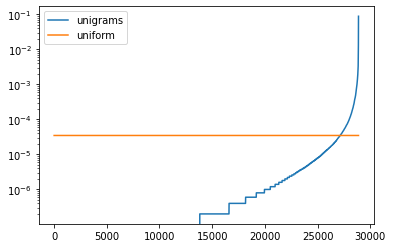

In [6]:
import matplotlib.pyplot as plt

uni_values = torch.arange(106, len(tkz)-3)
uni_dfs = [train_uni_df[t.item()] for t in uni_values]
unigram_dist = torch.distributions.Categorical(probs=torch.tensor(uni_dfs) / sum(uni_dfs))

random_dist = torch.distributions.Categorical(probs = torch.ones_like(uni_values) / uni_values.size(0))

plt.plot(unigram_dist.probs.sort().values, label="unigrams")
plt.plot(random_dist.probs, label="uniform")
plt.legend()
plt.yscale('log')

Sample new captions with uniform token distribution. The length is sampled from a gaussian distribution with $\mu = \frac{1}{5} \sum_{s_{ij}} l_{ij}$  and $\sigma = \frac{1}{2}\frac{1}{5} \sum_{s_{ij}} \left(l_{ij} - \mu\right)^2$

In [12]:
def compute_random_cider(val_refs, distribution):
    cands = {}

    ref_lens = np.array([[len(x) for x in refs] for refs in val_refs.values()])
    cand_lens = np.floor(np.random.randn(ref_lens.shape[0]) * ref_lens.std(axis=-1) / 2 + ref_lens.mean(axis=-1)).astype(int)
    cand_samples = np.random.randint(106, len(tkz)-3, size=(cand_lens.shape[0], cand_lens.max()))
    
    all_tokens = torch.arange(106, len(tkz)-3)
    cand_samples = all_tokens[distribution.sample((cand_lens.shape[0], cand_lens.max()))].numpy()

    for imgid, cand, new_len in zip(val_refs.keys(), cand_samples, cand_lens):
        c = cand[:new_len].tolist()
        cands[imgid] = [c]
        
    cider = MyCider(n = 4)
    for id in val_refs.keys():
        cider.add_sample(cands[id][0], val_refs[id])
        
    score, std = cider.calc_score(silent=True)
    return score

In [16]:
def compute_ref_cider(val_refs):    
    cands = {}

    for imgid in val_refs.keys():
        c = random.choice(val_refs[imgid])
        cands[imgid] = [c]
        
    cider = MyCider(n = 4)
    for id in val_refs.keys():
        cider.add_sample(cands[id][0], val_refs[id])
        
    score, std = cider.calc_score(silent=True)
    return score

### Uniform

In [14]:
scores = []
for _ in tqdm(range(10), desc="outer"):
    scores.append(compute_random_cider(val_refs, random_dist))
    
np.array(scores).mean()

outer:   0%|          | 0/10 [00:00<?, ?it/s]

0.0003735891453275005

#### Unigram

In [20]:
scores = []
for _ in tqdm(range(10), desc="outer"):
    scores.append(compute_random_cider(val_refs, unigram_dist))
    
np.array(scores).mean()

outer:   0%|          | 0/10 [00:00<?, ?it/s]

0.021405869583412174

#### Refrence

In [19]:
scores = []
for _ in tqdm(range(10), desc="outer"):
    scores.append(compute_ref_cider(val_refs))
    
np.array(scores).mean()

outer:   0%|          | 0/10 [00:00<?, ?it/s]

2.713984991921444